# Exploring the critical community size of an SIR model

The critical community size (CCS) refers to the minimum population size required for an infectious disease to persist in a community without going extinct due to random fluctuations.  It would be more accurate to refer to the critical birth cohort, since the key factor is really not the total population but the rate of influx of new susceptibles - however, CCS is the more commonly used term in the field, and we will follow that.  
As shown in [notebook 5](https://github.com/laser-base/laser-generic/blob/f58d3d8a9dfc213551c8a8b5b7c1ef764d5bebbd/notebooks/05_SIR_wbirths_age_distribution.ipynb) on the equilibrium age distribution, the SIR system has an endemic equilibrium solution

$$
(S^*, \: I^*, \: R^*) = N*(\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\
$$

and [notebook 6](https://github.com/laser-base/laser-generic/blob/50796ab5a253df168255e8a3ac54b766f6aa55d5/notebooks/06_SIR_wbirths_natural_periodicity.ipynb), illustrates the stochastic fluctuations in the infectious population around this equilibrium.  It stands to reason, then, the smaller the the equilibrium infected population $\frac{N \mu (R_0-1)}{\beta}$ (or more precisely, the larger the amplitude of fluctuations relative to $ I^* $), the more probable it becomes that the infected population will randomly fluctuate to 0.  In considering spatial patch models of disease transmission, this is a critical behavior that differentiates the disease dynamics of continuous vs. discrete models, and of spatially structured models with many small populations from unstructured models of large populations.  Modeling the spatial population and connectivity structure is thus essential for understanding how local extinctions and reintroductions shape disease persistence at larger scales.

While the intuition makes sense, there's not a single, shared mathematically precise definition of the critical community size - how probable does a stochastic extinction need to be, within how long of a time window, to draw a dividing line between above and below the CCS?  Different authors have taken different approaches to defining CCS and analyzing the system and found slightly different approximations to the CCS.  In Nasell, Theoretical Population Biology 67 (2005) 203–216, we find three formulae (the third credited to Diekmann & Heesterbeek, Mathematical Epidemiology
of Infectious Diseases (2000)):

$$
N_{crit,1} = \frac{2 \pi}{log(2)} \frac{\alpha^\frac{3}{2} R_0}{(R_0-1)^\frac{3}{2}}
$$

$$
N_{crit,2} = \frac{K \alpha^2 R_0}{R_0-1}
$$

$$ 
N_{crit,3} = \frac{\alpha^2 R_0^2}{(R_0-1)^2}
$$

where $\alpha = \frac{\gamma + \mu}{\mu}$, and $K$ represents a chosen time horizon in units of $\mu$.  There are slight differences in functional form between these, but what they share in common provides some good intuiation.  First, a strong dependence on the ratio of $\gamma$ to $\mu$ - that is, how long is the infectious period relative to the timescale of susceptible replenishment.  Second, relatively weak dependence on $R_0$ as long as it's reasonably larger than 1.  One might expect $R_0$ to play a large role here, but in fact all diseases seek $R_{eff} \approx 1$ near the endemic equilibrium, and so the impact of $R_0$ on pathogen survival is weak unless $R_0$ is quite small.

In this notebook, we will demonstrate ability to reproduce the CCS phenomenon, and fit CCS against the $\alpha$ & $R_0$ parameters to see which, if any, of the above formula we reproduce.  To do this, we will construct the first patch model in this series of notebooks, setting up each simulation with a set of patches covering a couple orders of magnitude in population size from the smallest to the largest.  As the concept of CCS is defined for a population, we will not yet connect these population patches to each other (that will come in the next notebooks), but will let the disease dynamics play out independently in each to see where the disease persists and where it self-extinguishes.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser.generic import SIR
from laser.generic import Model
from laser.generic.utils import ValuesMap
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator
from laser.core.utils import grid
import laser.core
import laser.generic
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


np.__version__='2.2.6'
laser.core.__version__='0.9.1'
laser.generic.__version__='0.0.0'


In [2]:
class Importation_EachNode:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3, duration: int = 20*365):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count
        self.duration = duration

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0 and tick < self.duration:
            i_susceptible = np.nonzero(self.model.people.state == SIR.State.SUSCEPTIBLE.value)[0]
            n_susceptible = self.model.people.nodeid[i_susceptible]
            for node in np.unique(self.model.people.nodeid):
                these_susceptibles = i_susceptible[n_susceptible==node]
                if len(these_susceptibles) > 0:
                    count = min(self.count, len(these_susceptibles))
                    i_infect = np.random.choice(these_susceptibles, size=count, replace=False)
                    self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                    samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                    samples = np.round(samples)
                    samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                    self.model.people.itimer[i_infect] = samples
                    self.model.nodes.S[tick + 1, node] -= count
                    self.model.nodes.I[tick + 1, node] += count
                    self.model.nodes.imports[tick, node] = count
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return

# _Important_

Note that running the 200 simulations below takes a few hours even on modern hardware.

We have set `run_sims` to False by default. Change `run_sims` to True to (re)generate the results.


In [ ]:
run_sims = False
analyze_sims = True

In [12]:
npatches = 61
scenario = grid(M=1, N=npatches, population_fn=lambda x,y: np.ceil(10**(3 + y*(3/(npatches-1)))).astype(np.uint32), origin_x=0, origin_y=0)
initial_infected = 3
nticks = 40 * 365
nsims = 200
i = 0
start_from_last = False
outputs = None

if run_sims:

    i = 0

    if start_from_last:  #If we are resuming from a stopped previous run

        outputs =np.load(os.path.join("outputs", "CCS_outputs.npy"))
        while i < outputs.shape[0] and np.any(outputs[i]):
            i += 1
        R0_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))[0, :]
        infmean_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))[1, :]
        cbr_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))[2, :]

    else:
        
        R0_samples = np.random.uniform(1.05, 2.5, nsims)**3
        infmean_samples = 5 + np.random.gamma(2, 10, nsims)
        cbr_samples = 10 + np.random.gamma(2, 20, nsims)
        cbr_samples = np.clip(cbr_samples, 10, 100)
        np.save(os.path.join("outputs", "CCS_parameter_samples.npy"), np.vstack([R0_samples, infmean_samples, cbr_samples]))
        outputs = np.zeros((nsims, nticks+1, npatches), dtype=np.uint32)
    
    while i < nsims:

        R0 = R0_samples[i]
        infmean = infmean_samples[i]
        cbr = cbr_samples[i]
        print(f"Running simulation {i+1}/{nsims} with R0={R0:.2f}, infmean={infmean:.2f}, cbr={cbr:.2f}")

        scenario["I"] = initial_infected
        scenario["R"] = np.floor(scenario.population * (R0-1)/ R0).astype(np.uint32)
        scenario["S"] = scenario.population - scenario["I"] - scenario["R"]

        parameters = PropertySet(
            {
                "seed": np.random.randint(0, 1000000),
                "nticks": nticks,
                "verbose": True,
                "beta": R0 / infmean,
                "inf_mean": infmean,
                "cbr": cbr,
                "importation_period": 180,
                "importation_count": 3,
                "importation_end": 20 * 365,
            }
        )

        birthrate_map = ValuesMap.from_scalar(parameters.cbr, nticks=parameters.nticks, nnodes=len(scenario))
        infdurdist = dists.exponential(scale=parameters.inf_mean)
        rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
        stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
        pyramid = AliasedDistribution(stable_age_dist)
        survival = KaplanMeierEstimator(stable_age_dist.cumsum())
        model = Model(scenario, parameters, birthrates=birthrate_map.values)
        model.network = 0*model.network
        model.components = [
            SIR.Susceptible(model),
            SIR.Recovered(model),
            SIR.Infectious(model, infdurdist),
            Importation_EachNode(model, infdurdist, period=parameters.importation_period, count=parameters.importation_count, duration=parameters.importation_end),
            SIR.Transmission(model, infdurdist),
            BirthsByCBR(model, birthrate_map.values, pyramid),
            MortalityByEstimator(model, estimator=survival),        
        ]
        model.run()
        outputs[i, :, :] = model.nodes.I
        os.makedirs("outputs", exist_ok=True)
        np.save(os.path.join("outputs", "CCS_outputs.npy"), outputs)
        i+=1


Running simulation 1/200 with R0=3.79, infmean=20.99, cbr=46.56


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 136.54it/s]


Running simulation 2/200 with R0=6.83, infmean=29.59, cbr=22.97


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:17<00:00, 188.82it/s]


Running simulation 3/200 with R0=6.13, infmean=17.42, cbr=29.20


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:23<00:00, 174.64it/s]


Running simulation 4/200 with R0=10.09, infmean=41.78, cbr=35.96


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:24<00:00, 173.33it/s]


Running simulation 5/200 with R0=10.68, infmean=29.95, cbr=33.77


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:22<00:00, 177.78it/s]


Running simulation 6/200 with R0=12.11, infmean=13.05, cbr=17.36


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:08<00:00, 214.20it/s]


Running simulation 7/200 with R0=3.80, infmean=8.89, cbr=19.33


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:19<00:00, 183.92it/s]


Running simulation 8/200 with R0=3.97, infmean=40.10, cbr=28.17


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:27<00:00, 166.94it/s]


Running simulation 9/200 with R0=2.64, infmean=13.81, cbr=22.50


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:28<00:00, 165.06it/s]


Running simulation 10/200 with R0=3.24, infmean=28.30, cbr=21.80


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:23<00:00, 173.82it/s]


Running simulation 11/200 with R0=7.04, infmean=11.97, cbr=43.11


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:36<00:00, 150.89it/s]


Running simulation 12/200 with R0=8.47, infmean=13.69, cbr=38.10


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:30<00:00, 161.70it/s]


Running simulation 13/200 with R0=9.13, infmean=75.44, cbr=84.88


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:03<00:00, 118.67it/s]


Running simulation 14/200 with R0=4.38, infmean=72.50, cbr=23.26


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:18<00:00, 184.94it/s]


Running simulation 15/200 with R0=9.06, infmean=24.60, cbr=16.50


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:08<00:00, 213.62it/s]


Running simulation 16/200 with R0=15.44, infmean=55.61, cbr=15.18


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:00<00:00, 242.36it/s]


Running simulation 17/200 with R0=5.22, infmean=14.89, cbr=65.66


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:03<00:00, 118.56it/s]


Running simulation 18/200 with R0=3.24, infmean=26.48, cbr=78.38


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:13<00:00, 109.51it/s]


Running simulation 19/200 with R0=8.38, infmean=43.97, cbr=30.93


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:21<00:00, 179.39it/s]


Running simulation 20/200 with R0=3.98, infmean=13.07, cbr=37.11


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:32<00:00, 157.24it/s]


Running simulation 21/200 with R0=1.45, infmean=12.79, cbr=50.16


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:07<00:00, 114.53it/s]


Running simulation 22/200 with R0=3.62, infmean=5.53, cbr=58.78


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:55<00:00, 126.36it/s]


Running simulation 23/200 with R0=1.96, infmean=43.84, cbr=22.20


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:32<00:00, 158.54it/s]


Running simulation 24/200 with R0=8.53, infmean=57.44, cbr=37.04


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:25<00:00, 170.42it/s]


Running simulation 25/200 with R0=4.47, infmean=34.29, cbr=81.86


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:13<00:00, 109.43it/s]


Running simulation 26/200 with R0=1.38, infmean=26.42, cbr=12.32


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:28<00:00, 165.28it/s]


Running simulation 27/200 with R0=15.58, infmean=38.52, cbr=31.62


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:10<00:00, 207.94it/s]


Running simulation 28/200 with R0=1.44, infmean=7.00, cbr=24.90


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:40<00:00, 144.61it/s]


Running simulation 29/200 with R0=5.27, infmean=31.47, cbr=33.33


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:27<00:00, 166.27it/s]


Running simulation 30/200 with R0=1.86, infmean=14.42, cbr=52.81


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:02<00:00, 119.42it/s]


Running simulation 31/200 with R0=11.54, infmean=39.21, cbr=24.90


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:10<00:00, 208.09it/s]


Running simulation 32/200 with R0=3.46, infmean=23.58, cbr=36.06


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:34<00:00, 155.14it/s]


Running simulation 33/200 with R0=1.35, infmean=42.24, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:52<00:00, 84.53it/s]


Running simulation 34/200 with R0=10.77, infmean=39.74, cbr=54.55


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:35<00:00, 153.59it/s]


Running simulation 35/200 with R0=12.36, infmean=24.13, cbr=69.25


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:38<00:00, 147.57it/s]


Running simulation 36/200 with R0=6.75, infmean=27.59, cbr=94.16


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:14<00:00, 108.57it/s]


Running simulation 37/200 with R0=8.64, infmean=7.77, cbr=68.98


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:49<00:00, 133.12it/s]


Running simulation 38/200 with R0=12.15, infmean=31.76, cbr=62.10


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:36<00:00, 151.44it/s]


Running simulation 39/200 with R0=3.43, infmean=16.68, cbr=47.45


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:44<00:00, 139.26it/s]


Running simulation 40/200 with R0=2.26, infmean=12.66, cbr=50.53


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:55<00:00, 125.93it/s]


Running simulation 41/200 with R0=4.56, infmean=34.87, cbr=41.90


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:36<00:00, 150.62it/s]


Running simulation 42/200 with R0=11.32, infmean=9.86, cbr=97.65


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:54<00:00, 127.30it/s]


Running simulation 43/200 with R0=2.36, infmean=20.54, cbr=100.00


9,187,314 agents in 61 node(s):  33%|███▎      | 4852/14600 [00:35<01:24, 115.25it/s]ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 341, in dispatch_control
    await self.process_control(msg)
  File "/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 347, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/jupyter_client/session.py", line 994, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in ms

Running simulation 44/200 with R0=3.03, infmean=9.08, cbr=22.98


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:24<00:00, 173.58it/s]


Running simulation 45/200 with R0=10.83, infmean=26.36, cbr=27.77


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:15<00:00, 192.92it/s]


Running simulation 46/200 with R0=1.85, infmean=12.61, cbr=39.21


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:50<00:00, 132.53it/s]


Running simulation 47/200 with R0=1.94, infmean=13.22, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:42<00:00, 90.01it/s]


Running simulation 48/200 with R0=13.20, infmean=32.44, cbr=76.47


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:41<00:00, 144.47it/s]


Running simulation 49/200 with R0=9.96, infmean=18.11, cbr=34.14


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:21<00:00, 179.40it/s]


Running simulation 50/200 with R0=2.16, infmean=10.84, cbr=39.82


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 136.69it/s]


Running simulation 51/200 with R0=3.76, infmean=14.81, cbr=22.50


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:20<00:00, 181.33it/s]


Running simulation 52/200 with R0=15.22, infmean=27.61, cbr=52.22


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:23<00:00, 174.00it/s]


Running simulation 53/200 with R0=11.65, infmean=9.82, cbr=51.30


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:31<00:00, 159.45it/s]


Running simulation 54/200 with R0=2.90, infmean=12.53, cbr=46.05


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:48<00:00, 134.56it/s]


Running simulation 55/200 with R0=15.21, infmean=42.06, cbr=42.47


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:18<00:00, 184.86it/s]


Running simulation 56/200 with R0=3.40, infmean=56.10, cbr=85.02


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:20<00:00, 104.20it/s]


Running simulation 57/200 with R0=12.93, infmean=24.83, cbr=39.14


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:19<00:00, 182.62it/s]


Running simulation 58/200 with R0=4.87, infmean=11.80, cbr=57.65


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:50<00:00, 132.70it/s]


Running simulation 59/200 with R0=1.18, infmean=26.12, cbr=53.25


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:15<00:00, 107.45it/s]


Running simulation 60/200 with R0=13.03, infmean=7.07, cbr=28.58


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:13<00:00, 199.72it/s]


Running simulation 61/200 with R0=7.45, infmean=56.02, cbr=68.39


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:54<00:00, 127.13it/s]


Running simulation 62/200 with R0=8.89, infmean=19.68, cbr=57.39


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:41<00:00, 143.87it/s]


Running simulation 63/200 with R0=1.53, infmean=25.40, cbr=38.18


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:55<00:00, 126.83it/s]


Running simulation 64/200 with R0=2.42, infmean=14.91, cbr=33.99


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:39<00:00, 146.58it/s]


Running simulation 65/200 with R0=3.54, infmean=28.01, cbr=26.55


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:24<00:00, 172.24it/s]


Running simulation 66/200 with R0=5.56, infmean=32.50, cbr=89.10


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:14<00:00, 108.38it/s]


Running simulation 67/200 with R0=3.25, infmean=32.80, cbr=24.93


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:24<00:00, 172.18it/s]


Running simulation 68/200 with R0=2.25, infmean=30.68, cbr=31.47


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:38<00:00, 147.73it/s]


Running simulation 69/200 with R0=3.89, infmean=30.43, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:28<00:00, 98.09it/s]


Running simulation 70/200 with R0=13.41, infmean=19.02, cbr=35.42


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:16<00:00, 191.44it/s]


Running simulation 71/200 with R0=7.96, infmean=42.97, cbr=41.85


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:31<00:00, 159.41it/s]


Running simulation 72/200 with R0=12.23, infmean=53.07, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:57<00:00, 124.61it/s]


Running simulation 73/200 with R0=4.15, infmean=16.64, cbr=52.11


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:48<00:00, 135.06it/s]


Running simulation 74/200 with R0=3.22, infmean=19.16, cbr=62.79


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:59<00:00, 122.33it/s]


Running simulation 75/200 with R0=10.37, infmean=53.01, cbr=24.41


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:11<00:00, 203.25it/s]


Running simulation 76/200 with R0=6.22, infmean=13.60, cbr=50.14


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:41<00:00, 144.02it/s]


Running simulation 77/200 with R0=4.49, infmean=20.83, cbr=93.83


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:21<00:00, 102.91it/s]


Running simulation 78/200 with R0=4.61, infmean=16.93, cbr=52.99


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 136.79it/s]


Running simulation 79/200 with R0=5.84, infmean=8.85, cbr=35.81


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:26<00:00, 169.57it/s]


Running simulation 80/200 with R0=5.56, infmean=25.01, cbr=57.06


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:49<00:00, 133.63it/s]


Running simulation 81/200 with R0=1.57, infmean=21.38, cbr=23.43


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:38<00:00, 148.88it/s]


Running simulation 82/200 with R0=1.20, infmean=24.88, cbr=53.62


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:16<00:00, 106.96it/s]


Running simulation 83/200 with R0=8.41, infmean=27.88, cbr=60.58


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:45<00:00, 138.34it/s]


Running simulation 84/200 with R0=4.96, infmean=15.41, cbr=17.53


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:11<00:00, 205.19it/s]


Running simulation 85/200 with R0=1.51, infmean=21.90, cbr=31.06


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:47<00:00, 135.69it/s]


Running simulation 86/200 with R0=2.10, infmean=9.53, cbr=69.71


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:14<00:00, 108.76it/s]


Running simulation 87/200 with R0=4.89, infmean=27.34, cbr=18.01


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:12<00:00, 200.74it/s]


Running simulation 88/200 with R0=10.99, infmean=30.58, cbr=25.62


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:11<00:00, 203.23it/s]


Running simulation 89/200 with R0=13.92, infmean=27.78, cbr=47.63


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:23<00:00, 174.74it/s]


Running simulation 90/200 with R0=1.57, infmean=34.12, cbr=18.42


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:32<00:00, 157.93it/s]


Running simulation 91/200 with R0=5.48, infmean=16.79, cbr=26.69


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:19<00:00, 183.90it/s]


Running simulation 92/200 with R0=7.81, infmean=29.34, cbr=66.16


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:51<00:00, 131.10it/s]


Running simulation 93/200 with R0=4.80, infmean=11.38, cbr=36.43


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:30<00:00, 161.41it/s]


Running simulation 94/200 with R0=13.26, infmean=36.03, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:50<00:00, 131.77it/s]


Running simulation 95/200 with R0=10.88, infmean=29.23, cbr=56.73


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:36<00:00, 151.24it/s]


Running simulation 96/200 with R0=1.41, infmean=21.58, cbr=16.10


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:31<00:00, 159.37it/s]


Running simulation 97/200 with R0=8.39, infmean=11.59, cbr=61.65


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 137.49it/s]


Running simulation 98/200 with R0=10.85, infmean=29.14, cbr=43.72


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:27<00:00, 167.25it/s]


Running simulation 99/200 with R0=12.57, infmean=12.97, cbr=41.80


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:22<00:00, 177.61it/s]


Running simulation 100/200 with R0=7.37, infmean=31.99, cbr=36.06


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:27<00:00, 167.53it/s]


Running simulation 101/200 with R0=4.81, infmean=36.18, cbr=21.43


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:15<00:00, 192.62it/s]


Running simulation 102/200 with R0=7.52, infmean=27.30, cbr=87.91


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:05<00:00, 115.97it/s]


Running simulation 103/200 with R0=2.40, infmean=24.76, cbr=36.50


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:43<00:00, 141.58it/s]


Running simulation 104/200 with R0=2.64, infmean=21.86, cbr=42.85


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 136.71it/s]


Running simulation 105/200 with R0=5.41, infmean=34.11, cbr=35.15


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:28<00:00, 164.30it/s]


Running simulation 106/200 with R0=8.53, infmean=56.15, cbr=61.59


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 137.24it/s]


Running simulation 107/200 with R0=1.51, infmean=35.09, cbr=69.28


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:23<00:00, 102.01it/s]


Running simulation 108/200 with R0=11.44, infmean=26.61, cbr=62.83


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:38<00:00, 147.95it/s]


Running simulation 109/200 with R0=2.81, infmean=11.45, cbr=68.46


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:07<00:00, 114.46it/s]


Running simulation 110/200 with R0=6.83, infmean=17.00, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:14<00:00, 108.74it/s]


Running simulation 111/200 with R0=4.14, infmean=50.40, cbr=40.91


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:38<00:00, 148.85it/s]


Running simulation 112/200 with R0=7.57, infmean=46.79, cbr=35.62


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:26<00:00, 167.85it/s]


Running simulation 113/200 with R0=3.75, infmean=33.83, cbr=58.71


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:54<00:00, 127.32it/s]


Running simulation 114/200 with R0=12.27, infmean=37.61, cbr=89.52


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:49<00:00, 132.84it/s]


Running simulation 115/200 with R0=3.40, infmean=28.43, cbr=45.73


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:43<00:00, 140.96it/s]


Running simulation 116/200 with R0=1.57, infmean=22.12, cbr=38.32


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:53<00:00, 128.39it/s]


Running simulation 117/200 with R0=15.42, infmean=18.17, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:42<00:00, 142.49it/s]


Running simulation 118/200 with R0=15.01, infmean=7.26, cbr=16.19


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:01<00:00, 236.96it/s]


Running simulation 119/200 with R0=2.70, infmean=8.77, cbr=30.61


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:34<00:00, 153.97it/s]


Running simulation 120/200 with R0=1.66, infmean=18.14, cbr=39.91


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:53<00:00, 128.34it/s]


Running simulation 121/200 with R0=5.43, infmean=24.26, cbr=32.42


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:28<00:00, 165.03it/s]


Running simulation 122/200 with R0=2.59, infmean=25.44, cbr=39.30


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:44<00:00, 139.40it/s]


Running simulation 123/200 with R0=2.13, infmean=13.54, cbr=42.92


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:50<00:00, 132.42it/s]


Running simulation 124/200 with R0=13.51, infmean=9.43, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:48<00:00, 134.94it/s]


Running simulation 125/200 with R0=13.78, infmean=24.33, cbr=90.64


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:44<00:00, 139.30it/s]


Running simulation 126/200 with R0=1.39, infmean=18.55, cbr=32.40


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:50<00:00, 132.55it/s]


Running simulation 127/200 with R0=1.48, infmean=15.50, cbr=20.49


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:35<00:00, 152.51it/s]


Running simulation 128/200 with R0=3.60, infmean=30.19, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:30<00:00, 97.12it/s]


Running simulation 129/200 with R0=4.54, infmean=33.02, cbr=75.56


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:08<00:00, 113.87it/s]


Running simulation 130/200 with R0=12.57, infmean=23.91, cbr=56.83


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:34<00:00, 154.23it/s]


Running simulation 131/200 with R0=12.09, infmean=32.20, cbr=71.41


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:41<00:00, 143.85it/s]


Running simulation 132/200 with R0=14.43, infmean=36.83, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:47<00:00, 135.32it/s]


Running simulation 133/200 with R0=1.42, infmean=30.88, cbr=15.72


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:31<00:00, 158.86it/s]


Running simulation 134/200 with R0=2.76, infmean=10.03, cbr=37.36


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:39<00:00, 146.55it/s]


Running simulation 135/200 with R0=1.36, infmean=33.36, cbr=24.87


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:42<00:00, 142.65it/s]


Running simulation 136/200 with R0=12.14, infmean=47.61, cbr=23.58


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:08<00:00, 212.97it/s]


Running simulation 137/200 with R0=15.04, infmean=30.96, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:45<00:00, 137.88it/s]


Running simulation 138/200 with R0=13.66, infmean=30.86, cbr=43.94


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:22<00:00, 177.68it/s]


Running simulation 139/200 with R0=2.51, infmean=15.37, cbr=17.35


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:21<00:00, 179.25it/s]


Running simulation 140/200 with R0=5.86, infmean=24.08, cbr=59.72


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:53<00:00, 128.53it/s]


Running simulation 141/200 with R0=6.96, infmean=12.51, cbr=51.95


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:42<00:00, 142.98it/s]


Running simulation 142/200 with R0=4.18, infmean=40.08, cbr=28.01


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:24<00:00, 173.02it/s]


Running simulation 143/200 with R0=11.78, infmean=8.57, cbr=28.21


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:13<00:00, 198.58it/s]


Running simulation 144/200 with R0=3.53, infmean=21.17, cbr=64.98


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:01<00:00, 120.61it/s]


Running simulation 145/200 with R0=7.47, infmean=13.29, cbr=64.52


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:50<00:00, 132.47it/s]


Running simulation 146/200 with R0=10.51, infmean=14.25, cbr=35.86


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:22<00:00, 177.64it/s]


Running simulation 147/200 with R0=7.70, infmean=10.66, cbr=25.99


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:15<00:00, 192.50it/s]


Running simulation 148/200 with R0=11.61, infmean=38.81, cbr=33.16


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:17<00:00, 187.42it/s]


Running simulation 149/200 with R0=8.29, infmean=13.85, cbr=36.09


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:26<00:00, 168.74it/s]


Running simulation 150/200 with R0=6.07, infmean=39.78, cbr=38.39


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:32<00:00, 157.28it/s]


Running simulation 151/200 with R0=5.97, infmean=70.28, cbr=68.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:00<00:00, 121.08it/s]


Running simulation 152/200 with R0=12.15, infmean=25.07, cbr=22.52


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:07<00:00, 214.76it/s]


Running simulation 153/200 with R0=11.69, infmean=11.50, cbr=24.71


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:11<00:00, 204.60it/s]


Running simulation 154/200 with R0=5.87, infmean=49.17, cbr=23.72


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:16<00:00, 190.52it/s]


Running simulation 155/200 with R0=8.46, infmean=13.73, cbr=62.83


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 137.20it/s]


Running simulation 156/200 with R0=4.98, infmean=29.87, cbr=22.89


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:17<00:00, 187.91it/s]


Running simulation 157/200 with R0=1.38, infmean=17.86, cbr=44.11


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:03<00:00, 118.64it/s]


Running simulation 158/200 with R0=2.73, infmean=7.19, cbr=19.32


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:21<00:00, 179.46it/s]


Running simulation 159/200 with R0=5.66, infmean=15.20, cbr=59.75


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:51<00:00, 130.85it/s]


Running simulation 160/200 with R0=5.20, infmean=30.97, cbr=16.94


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:11<00:00, 204.92it/s]


Running simulation 161/200 with R0=1.65, infmean=22.99, cbr=79.96


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:31<00:00, 96.33it/s]


Running simulation 162/200 with R0=2.39, infmean=36.11, cbr=68.63


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:10<00:00, 111.50it/s]


Running simulation 163/200 with R0=7.13, infmean=9.94, cbr=39.47


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:28<00:00, 164.49it/s]


Running simulation 164/200 with R0=8.55, infmean=18.92, cbr=47.35


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:34<00:00, 154.12it/s]


Running simulation 165/200 with R0=6.58, infmean=26.26, cbr=40.76


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:33<00:00, 156.68it/s]


Running simulation 166/200 with R0=6.44, infmean=30.65, cbr=39.59


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:31<00:00, 158.94it/s]


Running simulation 167/200 with R0=10.21, infmean=7.67, cbr=15.24


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:04<00:00, 225.79it/s]


Running simulation 168/200 with R0=7.46, infmean=35.21, cbr=82.93


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:03<00:00, 118.07it/s]


Running simulation 169/200 with R0=10.84, infmean=58.15, cbr=41.11


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:26<00:00, 169.62it/s]


Running simulation 170/200 with R0=1.60, infmean=20.31, cbr=19.77


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:33<00:00, 155.99it/s]


Running simulation 171/200 with R0=8.19, infmean=19.25, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:10<00:00, 112.05it/s]


Running simulation 172/200 with R0=4.09, infmean=28.08, cbr=64.71


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:59<00:00, 122.18it/s]


Running simulation 173/200 with R0=1.64, infmean=44.18, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:47<00:00, 87.36it/s]


Running simulation 174/200 with R0=1.27, infmean=13.01, cbr=27.24


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:46<00:00, 137.41it/s]


Running simulation 175/200 with R0=2.24, infmean=24.27, cbr=74.14


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:17<00:00, 105.82it/s]


Running simulation 176/200 with R0=5.99, infmean=21.59, cbr=65.24


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:56<00:00, 125.54it/s]


Running simulation 177/200 with R0=9.70, infmean=45.61, cbr=20.69


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:09<00:00, 211.01it/s]


Running simulation 178/200 with R0=10.32, infmean=49.03, cbr=38.35


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:24<00:00, 172.62it/s]


Running simulation 179/200 with R0=8.25, infmean=16.53, cbr=22.68


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:15<00:00, 194.44it/s]


Running simulation 180/200 with R0=7.07, infmean=18.84, cbr=82.05


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:04<00:00, 117.32it/s]


Running simulation 181/200 with R0=9.39, infmean=13.85, cbr=30.77


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:19<00:00, 184.48it/s]


Running simulation 182/200 with R0=9.24, infmean=18.05, cbr=56.58


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:40<00:00, 145.31it/s]


Running simulation 183/200 with R0=4.81, infmean=17.38, cbr=17.52


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:12<00:00, 201.44it/s]


Running simulation 184/200 with R0=1.94, infmean=17.11, cbr=25.42


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:35<00:00, 153.33it/s]


Running simulation 185/200 with R0=1.61, infmean=6.92, cbr=21.64


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:35<00:00, 153.16it/s]


Running simulation 186/200 with R0=8.71, infmean=13.26, cbr=37.09


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:26<00:00, 169.67it/s]


Running simulation 187/200 with R0=9.27, infmean=29.13, cbr=41.44


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:28<00:00, 164.81it/s]


Running simulation 188/200 with R0=11.39, infmean=25.24, cbr=37.05


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:20<00:00, 180.48it/s]


Running simulation 189/200 with R0=14.66, infmean=34.63, cbr=68.92


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:34<00:00, 154.66it/s]


Running simulation 190/200 with R0=4.04, infmean=39.72, cbr=47.56


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:45<00:00, 138.62it/s]


Running simulation 191/200 with R0=11.83, infmean=16.64, cbr=15.90


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:03<00:00, 229.93it/s]


Running simulation 192/200 with R0=4.22, infmean=23.02, cbr=53.09


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:48<00:00, 134.19it/s]


Running simulation 193/200 with R0=14.52, infmean=36.15, cbr=53.96


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:27<00:00, 167.67it/s]


Running simulation 194/200 with R0=2.16, infmean=25.87, cbr=18.90


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:25<00:00, 170.10it/s]


Running simulation 195/200 with R0=10.86, infmean=31.72, cbr=73.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:45<00:00, 137.92it/s]


Running simulation 196/200 with R0=7.45, infmean=43.09, cbr=47.23


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:37<00:00, 150.43it/s]


Running simulation 197/200 with R0=4.13, infmean=38.18, cbr=73.14


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:07<00:00, 114.34it/s]


Running simulation 198/200 with R0=1.66, infmean=34.39, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:46<00:00, 87.68it/s]


Running simulation 199/200 with R0=3.11, infmean=9.27, cbr=100.00


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [02:31<00:00, 96.41it/s]


Running simulation 200/200 with R0=13.04, infmean=36.37, cbr=36.62


9,187,314 agents in 61 node(s): 100%|██████████| 14600/14600 [01:17<00:00, 187.89it/s]


/var/folders/fl/_ns4br_j2qxd92vjrgl3t4n00000gn/T/ipykernel_72224/2173563150.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(outputs[0, :, :].T / pops[:, np.newaxis]), aspect="auto", origin="lower")


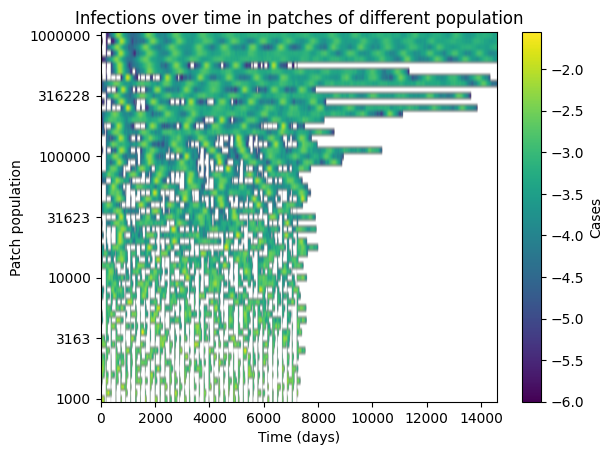

In [5]:
if analyze_sims:

    outputs = np.load(os.path.join("outputs", "CCS_outputs.npy"))
    parameter_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))
    R0_samples = parameter_samples[0, :]
    infmean_samples = parameter_samples[1, :]
    cbr_samples = parameter_samples[2, :]
    params_df = pd.DataFrame({
        "R0": R0_samples,
        "infmean": infmean_samples,
        "cbr": cbr_samples,
    })
    params_df['mu'] = (1 + params_df['cbr'] / 1000) ** (1 / 365) - 1
    params_df['alpha'] = (1 / params_df['infmean'] + params_df['mu'])/params_df['mu']
    nsims, nticks, npatches = outputs.shape

    pops = np.array(scenario.population)
    plt.imshow(np.log10(outputs[0, :, :].T / pops[:, np.newaxis]), aspect="auto", origin="lower")
    plt.colorbar(label="Cases")
    plt.xlabel("Time (days)")
    plt.ylabel("Patch population")
    plt.yticks(range(0, npatches, 10), pops[::10])
    plt.title("Infections over time in patches of different population")
    plt.show()


### Estimating the CCS

We will analyze two possible definitions for the CCS from our simulation outputs - the smallest population in which the disease persists through the end of simulation, and the largest population in which the disease fails to persist.   We will opt for the former definition as being more consistent with the definition - stochastic extinctions certianly can happen in above-CCS populations in a given sim, due to oscillations, relative timing of when we turn off new importations, etc.  Alternatively, we should never see disease persistence in sub-CCS populations, and so we will define our empirical estimate of the CCS to be (at most) the smallest population in which we do observe persistence.

In [6]:
if outputs is not None:

    CCS_est = []

    for sim in range(nsims):
        end_output = outputs[sim, -1, :]
        nonzero_pops = pops[end_output != 0]
        if len(nonzero_pops) > 0:
            CCS_est.append(np.min(nonzero_pops))
        else:
            CCS_est.append(np.max(pops))

    results_df = pd.DataFrame({"CCS_est": CCS_est})

    print(results_df)

else:
    results_df = None
    print("No simulation outputs found for analysis.")

     CCS_est
0     398108
1      14126
2     112202
3      35482
4      63096
..       ...
195   707946
196  1000000
197   177828
198    10000
199    50119

[200 rows x 1 columns]


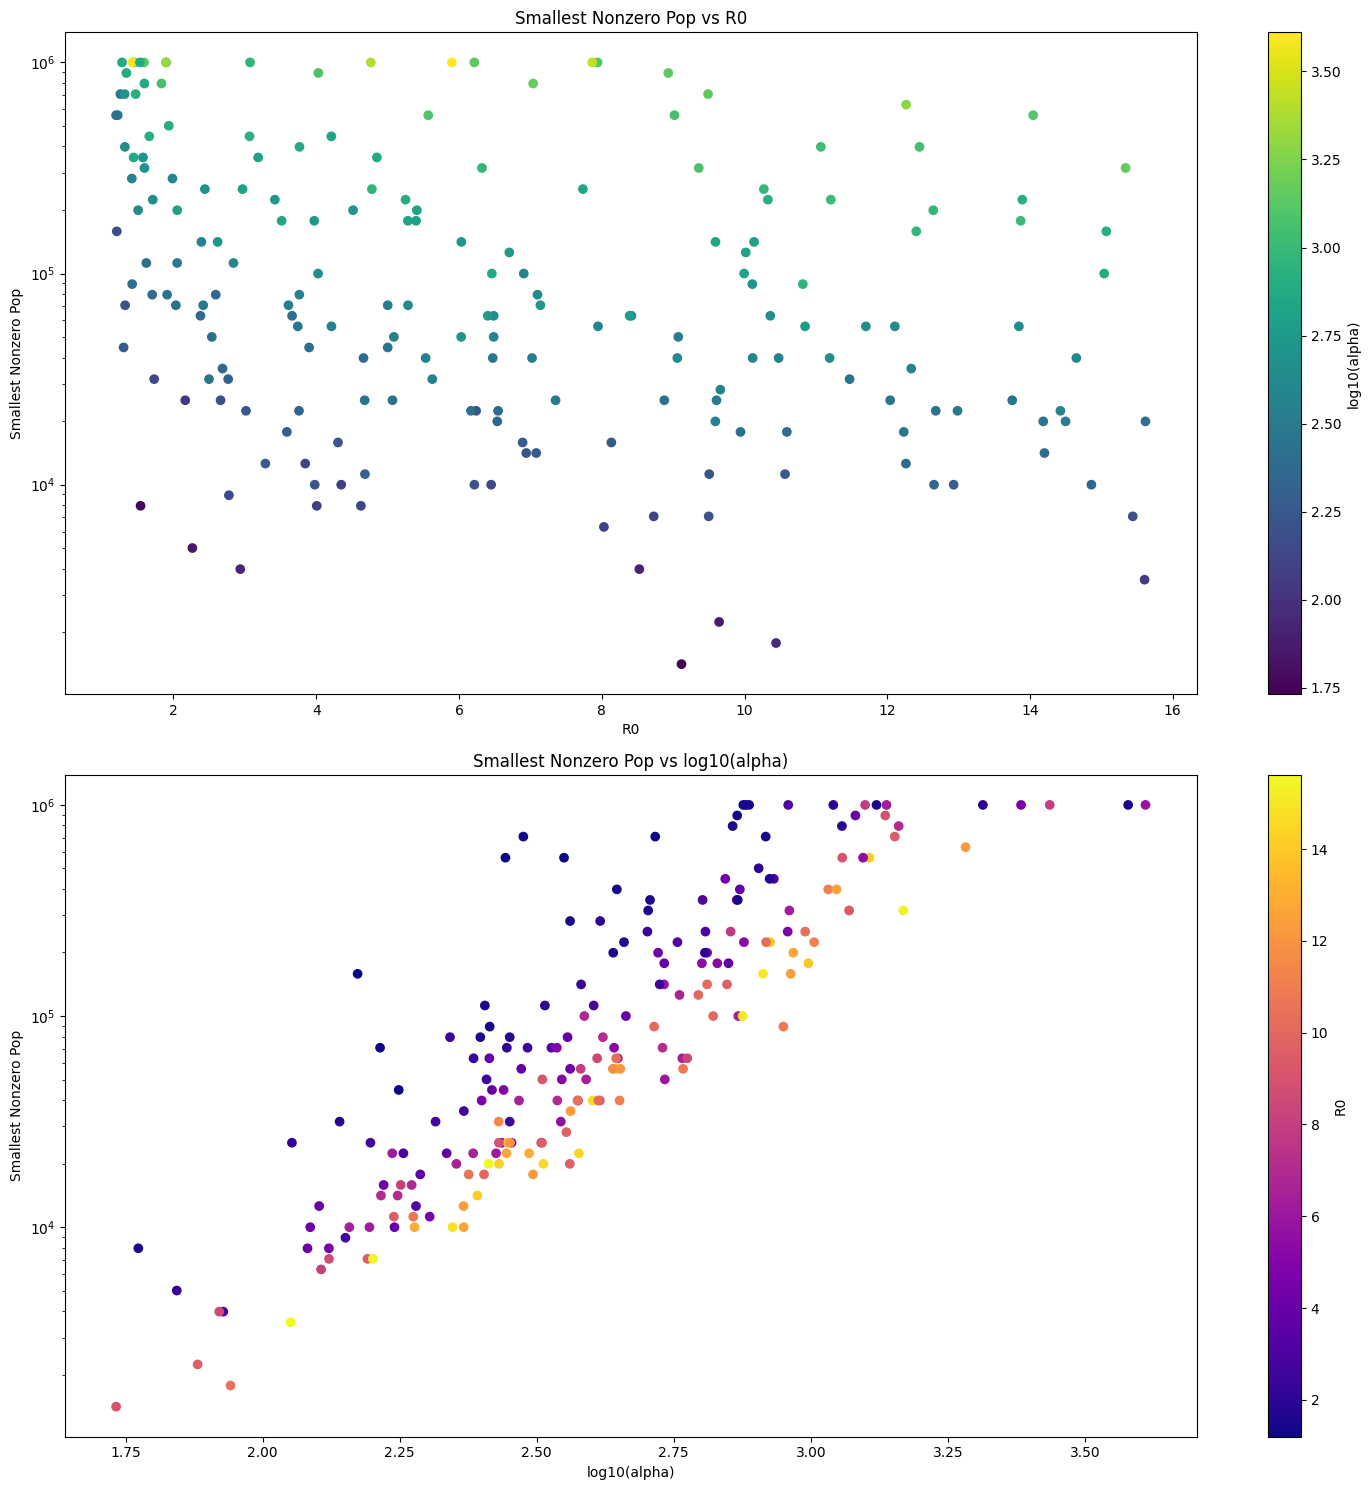

In [7]:
if results_df is not None:

    fig, axs = plt.subplots(2, 1, figsize=(15, 15))

    # Plot smallest_nonzero_pop against R0, colored by log10(alpha)
    sc3 = axs[0].scatter(params_df["R0"], results_df["CCS_est"], c=np.log10(params_df["alpha"]), cmap="viridis")
    axs[0].set_xlabel("R0")
    cbar1 = fig.colorbar(sc3, ax=axs[0])
    cbar1.set_label("log10(alpha)")
    axs[0].set_ylabel("Smallest Nonzero Pop")
    axs[0].set_title("Smallest Nonzero Pop vs R0")
    axs[0].set_yscale("log")

    # Plot smallest_nonzero_pop against log10(alpha), colored by R0
    sc4 = axs[1].scatter(np.log10(params_df["alpha"]), results_df["CCS_est"], c=params_df["R0"], cmap="plasma")
    axs[1].set_xlabel("log10(alpha)")
    cbar2 = fig.colorbar(sc4, ax=axs[1])
    cbar2.set_label("R0")
    axs[1].set_ylabel("Smallest Nonzero Pop")
    axs[1].set_title("Smallest Nonzero Pop vs log10(alpha)")
    axs[1].set_yscale("log")


    plt.tight_layout()
    plt.show()

else:
    print("No results to plot.")


OK, now we are going to start some fitting, to see whether our simulations reproduce something like the functional dependences above.

We are going to run into a bit of an inference power issue w/r/t dependence on the term of the form $\frac{R_0}{R0-1}$ - we are fitting a quantity (CCS) varying over orders of magnitude, with one parameter ($\alpha$) also varying over orders of magnitude, but this ratio being for the most part close to 1.  So we'll go ahead and assume one exponent for the ratio $\frac{R_0}{R0-1}$ for now, and simply see whether we recover something like the expected functional dependence.  

In [8]:
from scipy.optimize import curve_fit

# Define the fitting function for curve_fit
def fitting_function(X, constant, a, b):
    alpha, R0 = X
    return np.log10(constant) + a * np.log10(alpha) + b * np.log10(R0 / (R0 - 1))

if (results_df is not None) and (params_df is not None):

    # Since we are bounded above and below, filter out the max and min values of CCS_est
    inds2fit = (results_df["CCS_est"] != np.max(pops)) & (results_df["CCS_est"] != np.min(pops))

    # Prepare the data for multivariate fitting
    # Remove rows with NA in smallest_nonzero_pop
    alpha_values = params_df["alpha"][inds2fit].values
    R0_values = params_df["R0"][inds2fit].values
    CCS_est_values = results_df["CCS_est"][inds2fit].values

    # Stack alpha and R0 as input for curve_fit
    Xdata = np.vstack((alpha_values, R0_values))
    # Fit the function to the data
    popt, pcov = curve_fit(
        fitting_function,
        Xdata,
        CCS_est_values,
        bounds=([0.1, -2.5, -2.5], [100, 2.5, 2.5]),
        maxfev=10000
    )

    # # Extract the optimal parameters
    # constant_opt, a_opt, b_opt, c_opt = popt
    print(f"Optimal parameters:  constant = {popt[0]}, a = {popt[1]}, b = {popt[2]}")#, c = {popt[3]}")
    print(f"Covariance matrix:\n{pcov}")

else:

    alpha_values = None
    R0_values = None
    CCS_est_values = None

    print("No results available for curve fitting.")

Optimal parameters:  constant = 99.99999999999999, a = 2.4999999999999996, b = 2.4999999999999996
Covariance matrix:
[[ 1.40875732e+15 -2.30958599e+12 -8.21061972e+11]
 [-2.30958599e+12  3.88106270e+09  6.26814437e+08]
 [-8.21061972e+11  6.26814437e+08  1.30954585e+10]]


Looks pretty good - critically, we recover a dependence close to $\alpha^{3/2}$, matching one of the derived formulas above.  We also get a constant of order 1-10 (2 of the 3 formulas had a constant in this range).  Finally, we fit close to squared dependence on the ratio $\frac{R_0}{R_0-1}$ (this doesn't exactly match the formula with $\alpha^{3/2}$ dependence from the begining, but again we have very little no power on this term, as evidenced by the relatively large covariance on it).  Overall, reasonable fits here.

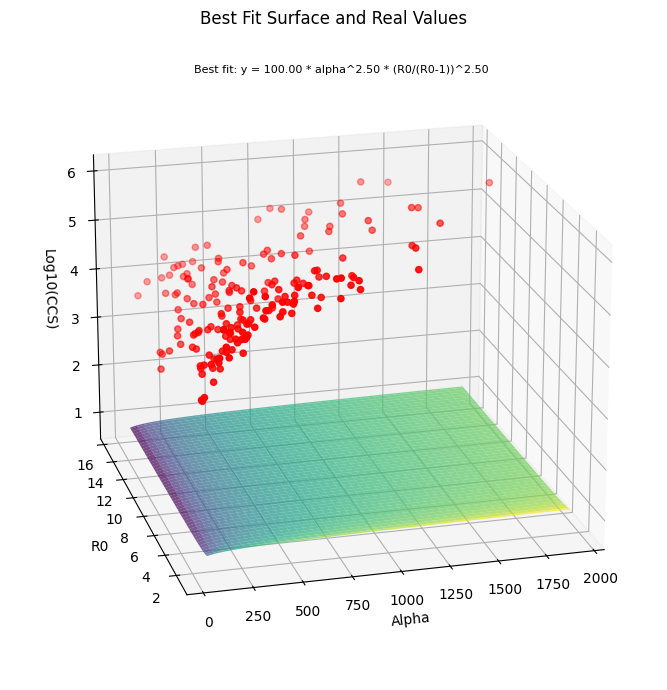

In [9]:
if (alpha_values is not None) and (R0_values is not None) and (CCS_est_values is not None):

    # # Create a meshgrid for alpha and R0 values
    alpha_fit = np.linspace(min(alpha_values), max(alpha_values), 100)
    R0_fit = np.linspace(min(R0_values), max(R0_values), 100)
    alpha_fit, R0_fit = np.meshgrid(alpha_fit, R0_fit)

    # # Calculate the best fit surface
    best_fit_surface = fitting_function((alpha_fit, R0_fit), popt[0], popt[1], popt[2])

    # Plot the best fit surface
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection="3d")


    # # Plot the best fit surface
    ax.plot_surface(alpha_fit, R0_fit, np.log10(best_fit_surface), cmap="viridis", alpha=0.7)

    # # Scatter the real values for comparison
    ax.scatter(alpha_values, R0_values, np.log10(CCS_est_values), color="red", label="Real Values")

    ax.set_xlabel("Alpha")
    ax.set_ylabel("R0")
    ax.set_zlabel("Log10(CCS)")
    ax.set_title("Best Fit Surface and Real Values")

    # # Add the best fit equation as a textbox
    equation_text = f"Best fit: y = {popt[0]:.2f} * alpha^{popt[1]:.2f} * (R0/(R0-1))^{popt[2]:.2f}"
    fig.text(.4, 0.9, equation_text, transform=fig.transFigure, fontsize=8, verticalalignment='top')

    plt.tight_layout()
    # # Rotate the camera for a better viewing angle
    ax.view_init(elev=20, azim=255)
    plt.show()

else:

    print("Insufficient data for 3D plotting.")

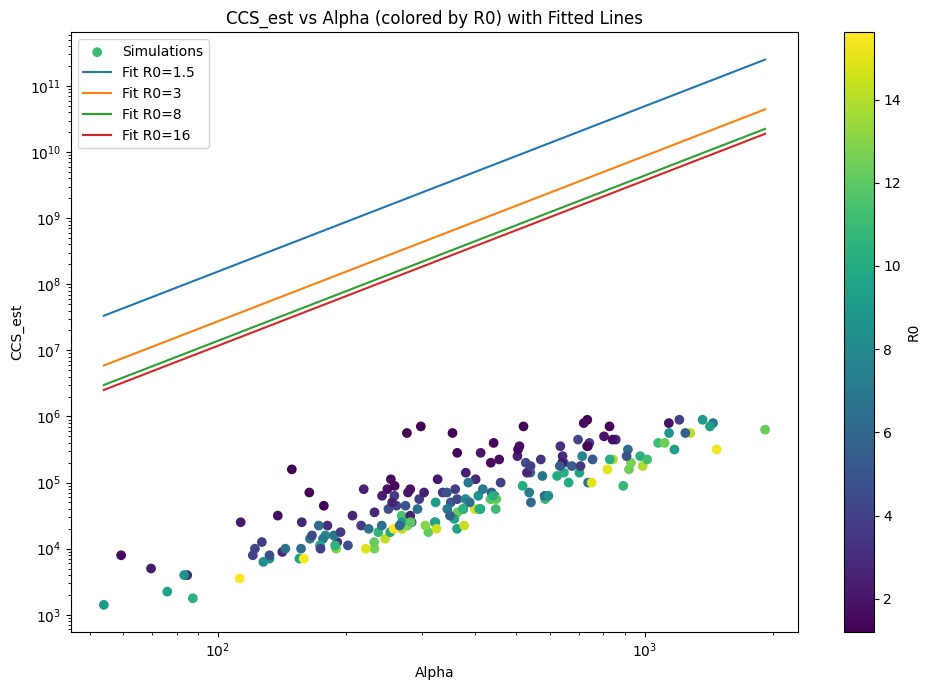

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot: CCS_est vs alpha, colored by R0
sc = ax.scatter(alpha_values, results_df["CCS_est"][inds2fit], c=R0_values, cmap="viridis", label="Simulations")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("R0")

# Fitted lines for selected R0 values
R0_lines = [1.5, 3, 8, 16]
alpha_range = np.logspace(np.log10(np.min(alpha_values)), np.log10(np.max(alpha_values)), 200)
for R0_val in R0_lines:
    CCS_fit = 10**(np.log10(popt[0]) + popt[1]*np.log10(alpha_range) + popt[2]*np.log10(R0_val/(R0_val-1)))
    ax.plot(alpha_range, CCS_fit, label=f"Fit R0={R0_val}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Alpha")
ax.set_ylabel("CCS_est")
ax.set_title("CCS_est vs Alpha (colored by R0) with Fitted Lines")
ax.legend()
plt.tight_layout()
plt.show()
